## Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from glob import glob

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error

import warnings
warnings.filterwarnings('ignore')

## Importing Data

In [3]:
# List of filenames containing our FOREX data
forex_tables_glob = glob("../data/*.xls")

def create_forex_df(all_files_glob=glob("../data/*.xls")):

    all_files = all_files_glob

    li = []

    for filename in all_files:
        tdf = pd.read_excel(filename, skiprows=5, na_values=['CLOSED', 'closed', 'Closed', ' --']).drop([0,1,2,3,4])
        tdf = tdf.rename(columns={'Units':'Date'})

        # Convert Date to Datetime type
        tdf['Date'] = pd.to_datetime(tdf['Date'])

        # Create time series index
        tdf = tdf.set_index('Date', drop=True)
        li.append(tdf)

    df = pd.concat(li, axis=0, sort=False)
    
    return df

data = create_forex_df(forex_tables_glob).astype('float')

## Train, Validation, Test Split

Train Data : 2017 to 2018\
Validation Data : 2019\
Test Data : Jan 2020 to Feb 2020

In [4]:
# Data after 2017 (past 3 years)
data_3yrs = data['2017':]
df = data_3yrs[['USD']]

print("Total data count = ", df.shape[0])
print("Number of missing values = ", df.isnull().sum().sum())
print()

# for i in range(1, 11):
#     label = "lag_{}".format(i)
#     df[label] = df['USD'].shift(i)
    
df = df.dropna(axis=0)

train_df = df['2017':'2018']
val_df = df['2019']
test_df = df['2020']

print("Count of dates in training data = ", train_df.shape[0])
print("Count of dates in validation data = ", val_df.shape[0])
print("Count of dates in test data = ", test_df.shape[0])

Total data count =  778
Number of missing values =  0

Count of dates in training data =  501
Count of dates in validation data =  251
Count of dates in test data =  26


#### Common Functions

**1. to calculate predictions using Moving average**\
**2. to calculate mean absolute percentage error**

In [5]:
def get_preds_mov_avg(df, target_col, N, pred_min, offset):
    """
    Given a dataframe, get prediction at timestep t using values from t-1, t-2, ..., t-N.
    Using simple moving average.
    Inputs
        df         : dataframe with the values you want to predict. Can be of any length.
        target_col : name of the column you want to predict e.g. 'adj_close'
        N          : get prediction at timestep t using values from t-1, t-2, ..., t-N
        pred_min   : all predictions should be >= pred_min
        offset     : for df we only do predictions for df[offset:]. e.g. offset can be size of training set
    Outputs
        pred_list  : list. The predictions for target_col. np.array of length len(df)-offset.
    """
    pred_list = df[target_col].rolling(window = N, min_periods=1).mean() # len(pred_list) = len(df)
    
    # Add one timestep to the predictions
    pred_list = np.concatenate((np.array([np.nan]), np.array(pred_list[:-1])))
    
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
    
    return pred_list[offset:]

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

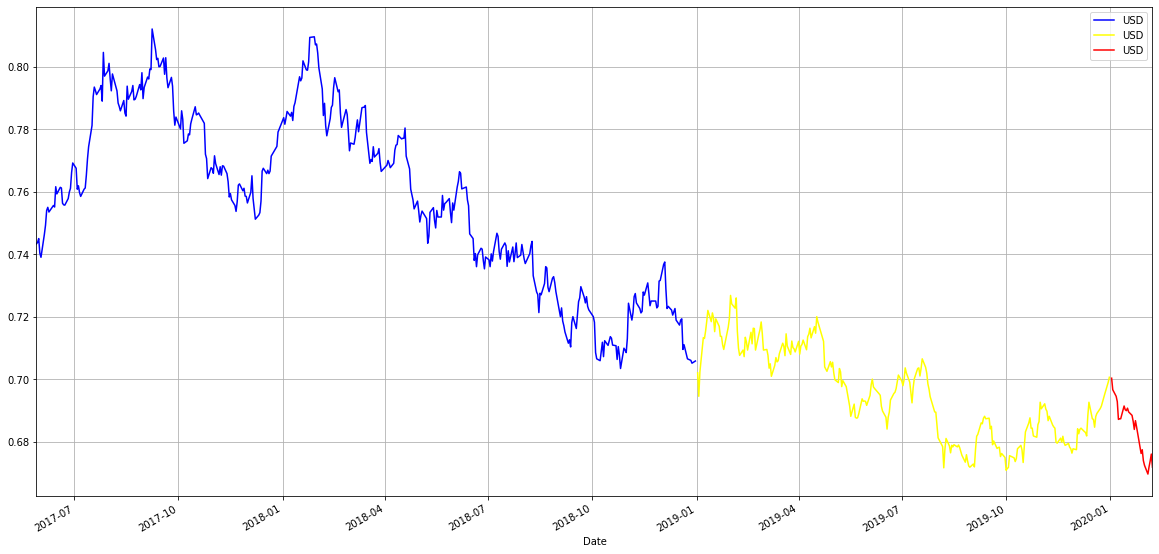

In [6]:
train_rate = train_df[['USD']][100:]
val_rate = val_df[['USD']]
test_rate = test_df[['USD']]

fig, ax = plt.subplots(figsize=(20,10))

train_rate.plot(ax=ax, color='blue', grid=True)
val_rate.plot(ax=ax, color='yellow', grid=True)
test_rate.plot(ax=ax, color='red', grid=True)

## Split into train, dev and test set

In [7]:
test_size = 0.2                 # proportion of dataset to be used as test set
cv_size = 0.2                   # proportion of dataset to be used as cross-validation set
Nmax = 21                       # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                                # Nmax is the maximum N we are going to test
fontsize = 14
ticklabelsize = 14

# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 468
num_cv = 155
num_test = 155
train.shape = (468, 1)
cv.shape = (155, 1)
train_cv.shape = (623, 1)
test.shape = (155, 1)


## Predict using Moving Average

In [8]:
import math
Nmax = 21

RMSE = []
mape = []
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list = get_preds_mov_avg(train_cv, 'USD', N, 0, num_train)
    
    cv.loc[:, 'est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['USD'])))
    mape.append(get_mape(cv['USD'], est_list))
    
# print('RMSE = ' + str(RMSE))
# print('MAPE = ' + str(mape))
cv.head()

,USD,est_N1,est_N2,est_N3,est_N4,est_N5,est_N6,est_N7,est_N8,est_N9,...,est_N12,est_N13,est_N14,est_N15,est_N16,est_N17,est_N18,est_N19,est_N20,est_N21
Date,,,,,,,,,,,,,,,,,,,,,
2018-11-13,0.7212,0.7226,0.72350,0.724800,0.725200,0.72442,0.723500,0.723614,0.722287,0.720756,...,0.717450,0.716700,0.716250,0.715587,0.715281,0.715024,0.714917,0.714847,0.714715,0.714529
2018-11-14,0.7217,0.7212,0.72190,0.722733,0.723900,0.72440,0.723883,0.723171,0.723312,0.722167,...,0.718933,0.717738,0.717021,0.716580,0.715938,0.715629,0.715367,0.715247,0.715165,0.715024
2018-11-15,0.7279,0.7217,0.72145,0.721833,0.722475,0.72346,0.723950,0.723571,0.722987,0.723133,...,0.719917,0.719146,0.718021,0.717333,0.716900,0.716276,0.715967,0.715700,0.715570,0.715476
2018-11-16,0.7269,0.7279,0.72480,0.723600,0.723350,0.72356,0.724200,0.724514,0.724112,0.723533,...,0.721467,0.720531,0.719771,0.718680,0.717994,0.717547,0.716922,0.716595,0.716310,0.716157
2018-11-19,0.7308,0.7269,0.72740,0.725500,0.724425,0.72406,0.724117,0.724586,0.724812,0.724422,...,0.723000,0.721885,0.720986,0.720247,0.719194,0.718518,0.718067,0.717447,0.717110,0.716814


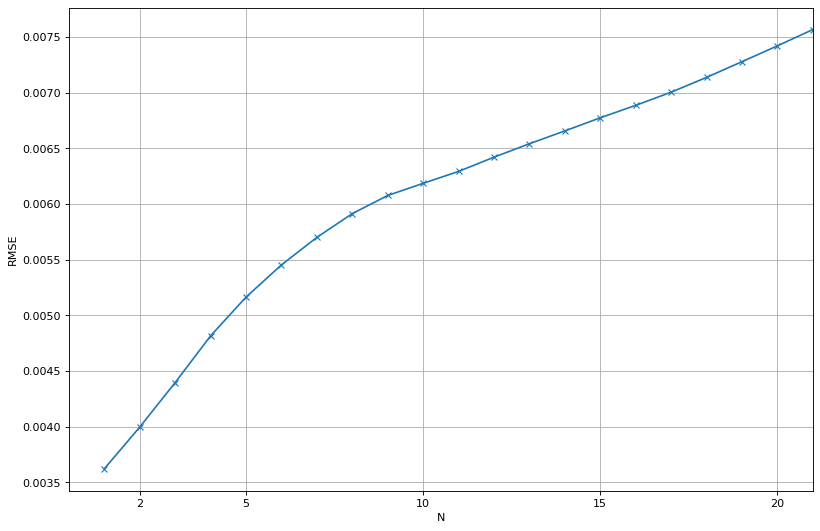

In [9]:
# Plot RMSE versus N
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')
plt.xlim([0, Nmax])
plt.xticks([2, 5, 10, 15, 20])
matplotlib.rcParams.update({'font.size': 14})

([<matplotlib.axis.XTick at 0x1d94e658ac8>,
 <a list of 5 Text xticklabel objects>)

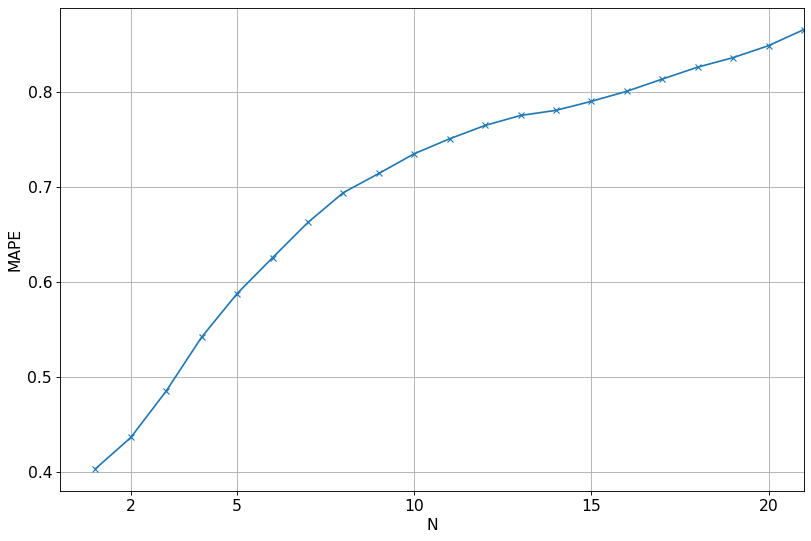

In [10]:
# Plot MAPE versus N. Note for MAPE smaller better. 
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), mape, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('MAPE')
plt.xlim([0, 21])
plt.xticks([2, 5, 10, 15, 20])

In [45]:
# Set optimum N
N_opt = 3

# Plot Predictions on validation data

Text(0, 0.5, 'USD')

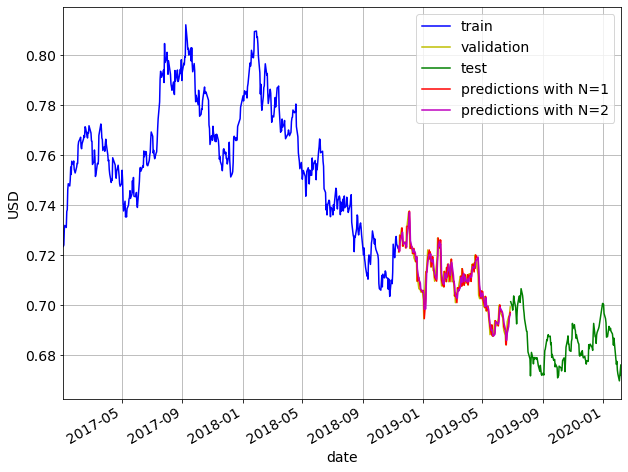

In [46]:
# Plot exchange rate over time
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(y='USD', style='b-', grid=True)
ax = cv.plot(y='USD', style='y-', grid=True, ax=ax)
ax = test.plot(y='USD', style='g-', grid=True, ax=ax)
ax = cv.plot(y='est_N1', style='r-', grid=True, ax=ax)
ax = cv.plot(y='est_N2', style='m-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N=1', 'predictions with N=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to dev set')

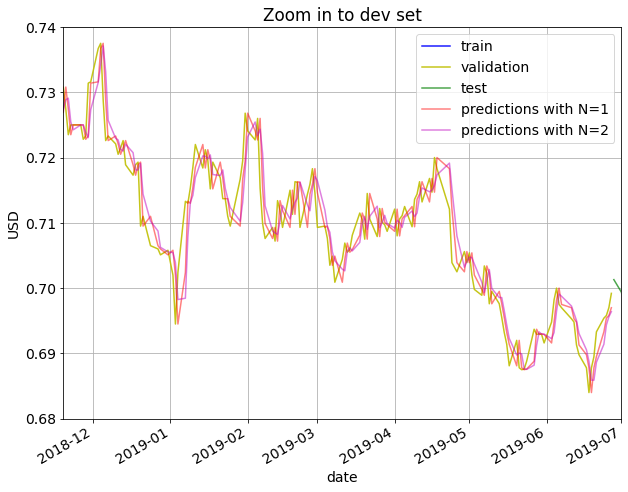

In [47]:
# Plot adjusted close over time
from datetime import date

rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(y='USD', style='b-', grid=True, alpha=0.9)
ax = cv.plot(y='USD', style='y-', grid=True, ax=ax, alpha=0.9)
ax = test.plot(y='USD', style='g-', grid=True, ax=ax, alpha=0.7)
ax = cv.plot(y='est_N1', style='r-', grid=True, ax=ax, alpha=0.5)
ax = cv.plot(y='est_N2', style='m-', grid=True, ax=ax, alpha=0.5)
ax.legend(['train', 'validation', 'test', 'predictions with N=1', 'predictions with N=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 11, 19), date(2019, 7, 1)])
ax.set_ylim([0.68, 0.74])
ax.set_title('Zoom in to dev set')

## Final Model

In [48]:
est_list = get_preds_mov_avg(df, 'USD', N_opt, 0, num_train+num_cv)
test.loc[:, 'est' + '_N' + str(N_opt)] = est_list
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['USD'])))
print("MAPE = %0.3f%%" % get_mape(test['USD'], est_list))
test.head()

RMSE = 0.004
MAPE = 0.419%


,USD,est_N2,est_N1,est_N3
Date,,,,
2019-06-28,0.7013,0.69810,0.6992,0.697333
2019-07-01,0.6994,0.70025,0.7013,0.699167
2019-07-02,0.6979,0.70035,0.6994,0.699967
2019-07-03,0.6998,0.69865,0.6979,0.699533
2019-07-04,0.7036,0.69885,0.6998,0.699033


Text(0, 0.5, 'USD')

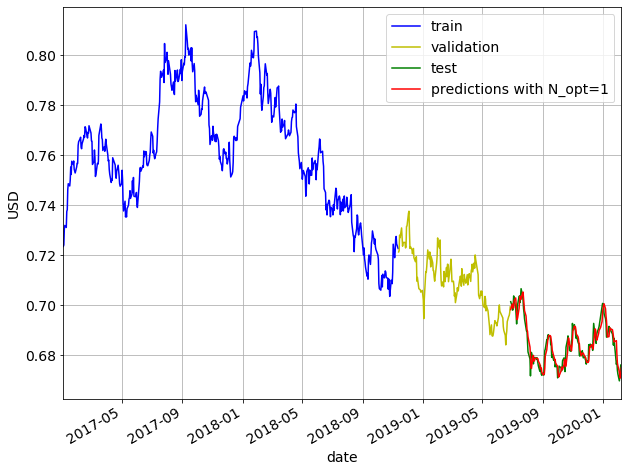

In [49]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(y='USD', style='b-', grid=True)
ax = cv.plot(y='USD', style='y-', grid=True, ax=ax)
ax = test.plot(y='USD', style='g-', grid=True, ax=ax)
ax = test.plot(y='est_N2', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N_opt=1'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

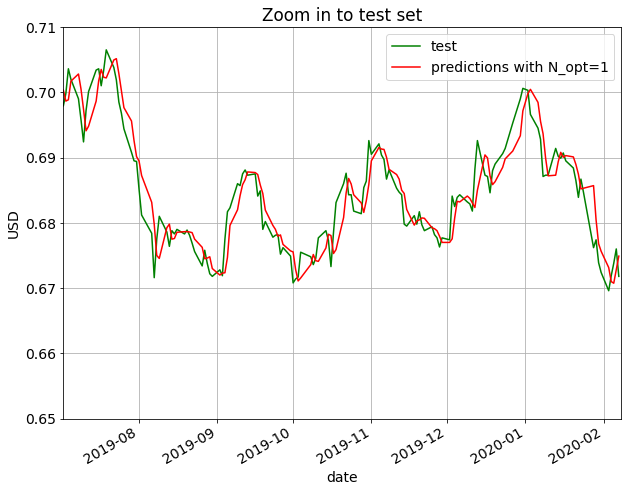

In [16]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

# ax = train.plot(y='USD', style='b', grid=True)
# ax = cv.plot(y='USD', style='y', grid=True, ax=ax)
ax = test.plot(y='USD', style='g', grid=True)
ax = test.plot(y='est_N2', style='r', grid=True, ax=ax)
ax.legend(['test', 'predictions with N_opt=1'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2019, 7, 2), date(2020, 2, 8)])
ax.set_ylim([0.65,0.71])
ax.set_title('Zoom in to test set')

(0.66, 0.72)

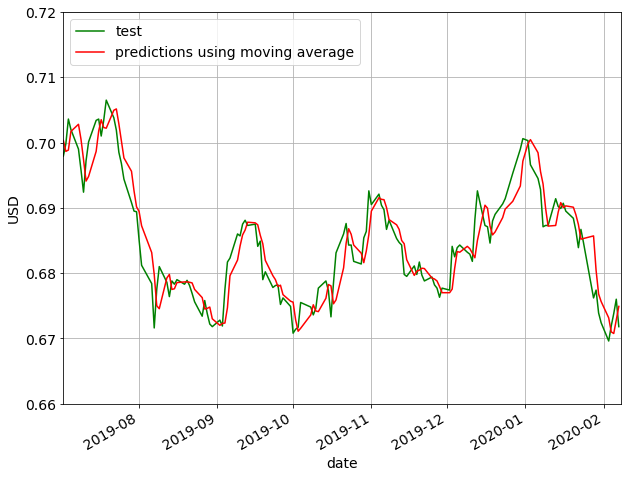

In [17]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(y='USD', style='g', grid=True)
ax = test.plot(y='est_N2', style='r', grid=True, ax=ax)
ax.legend(['test', 'predictions using moving average'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2019, 7, 2), date(2020, 2, 8)])
ax.set_ylim([0.66,0.72])

## Evaluate performance of MA models with different window sizes

In [18]:
def evaluate_MA(n):

    metrics = [r2_score, mean_absolute_error, mean_squared_error, median_absolute_error]
    metric_labels = ['r2_score', 'mean_absolute_error', 'mean_squared_error', 'median_absolute_error']

    model_names = ['MA {}'.format(N) for N in n]


    res = pd.DataFrame(index=[model_names], columns=metric_labels)

    for N, name in zip(n, model_names):
        results = []
        preds = get_preds_mov_avg(df, 'USD', N, 0, num_train+num_cv)

        for metric, label in zip(metrics, metric_labels):
            results.append(metric(test['USD'], preds))

        res.at[name,:] = results
        
    return res

# Show dataframe of evaluation metrics for different window sizes
n = [1, 2, 3, 4, 10, 21]
results = evaluate_MA(n)

results

,r2_score,mean_absolute_error,mean_squared_error,median_absolute_error
MA 1,0.904673,0.0021871,7.51148e-06,0.0018
MA 2,0.872449,0.00253613,1.00507e-05,0.0021
MA 3,0.8331,0.00286968,1.31513e-05,0.00236667
MA 4,0.794997,0.00317887,1.61537e-05,0.002725
MA 10,0.547688,0.00486832,3.5641e-05,0.00418
MA 21,0.184835,0.00672221,6.42328e-05,0.0059381


## Profits with different models

In [35]:

def buy_usd(aud_amt, exchange_rate):
    return aud_amt * exchange_rate

def buy_aud(usd_amt, exchange_rate):
    return usd_amt / exchange_rate

def buy_sell_plot(y, y_pred):
    buy_sell_df = pd.DataFrame(zip(y, y_pred), index = y.index, columns=['USD', 'Predictions'])
    
    buy_sell_df['predicted_change'] = buy_sell_df['Predictions'].diff().shift(-1)
    buy_sell_df['buy'] = buy_sell_df['predicted_change'].apply(lambda x: 1 if x >0 else (2 if x==0 else 0))

#     buy_sell_df['USD'].plot()
#     scatter = plt.scatter(buy_sell_df.index, buy_sell_df['USD'], c=buy_sell_df.buy)
#     legend = plt.legend(*scatter.legend_elements())
#     plt.title("Strategy on Predictions (Sell, Buy or Hold)")
#     plt.show()
    
    return buy_sell_df

def backtest(y, y_pred, initial_investment=1000, trade_amount=100):

    bsdf = pd.DataFrame(zip(y, y_pred), index = y.index, columns=['USD', 'Predictions'])
    
    bsdf['predicted_change'] = bsdf['Predictions'].diff().shift(-1)
    bsdf['buy'] = bsdf['predicted_change'].apply(lambda x: 1 if x >0 else (2 if x==0 else 0))

    logs = []
    profits = []

    strategy = bsdf.buy
    wallet = initial_investment
    
    for i in range(len(strategy)-1):
        rate_today = y[i]
        rate_future = y[i+1]
        buy = strategy[i]
#         print(buy)

        trade_money = trade_amount * rate_today
        wallet -= trade_amount

        if buy == 0:
            profit = trade_money - trade_amount * rate_future
        elif buy == 1:
            profit = trade_amount * rate_future - trade_money
        elif buy == 2:
            profit = 0
       
        
        if profit >= 0:
            wallet += trade_amount + profit
        else:
            wallet += trade_amount + profit

        logs.append(wallet)

    net_profit = wallet - initial_investment
    
#     plt.plot(bsdf.index[1:], logs)
#     plt.xticks(rotation=90)
#     plt.legend(["Net Profit = %.2f"%(net_profit)])
#     plt.title("Investment Growth over time")
#     plt.show()

    return net_profit, logs

def random_simulation(simulation_rate, ar_profit_on_same_data, limit=0.3):
    initial_investment = 1000
    trade_amount = 100

    profits = []

    for it in range(5000):

        random_strategy = np.random.randint(2, size=len(simulation_rate))

        wallet = initial_investment
        logs = []

        for i in range(len(random_strategy)-1):
            rate_today = simulation_rate[i]
            rate_future = simulation_rate[i+1]
            buy = random_strategy[i]

            trade_money = trade_amount * rate_today
            wallet -= trade_amount

            if buy == 0:
                profit = trade_money - trade_amount * rate_future
            elif buy == 1:
                profit = trade_amount * rate_future - trade_money
            elif buy == 2:
                profit = 0


            if profit >= 0:
                wallet += trade_amount + profit
            else:
                wallet += trade_amount + profit

            logs.append(wallet)

        net_profit = wallet - initial_investment

        profits.append(net_profit)
        
    legend_label = "Profit = %0.2f"%ar_profit_on_same_data

    sns.distplot(profits)
    plt.vlines(ar_profit_on_same_data, 0, limit, label='Profit with ARIMA Forecast')
    plt.legend([legend_label])
    plt.show()
    
def predict(train_data, n_steps):
    model = ARIMA(train_data, (4,1,4))
    model_fit = model.fit()

    predictions = model_fit.forecast(n_steps)[0]

    return predictions

def profit_dataframe(train_ts=train_ts, val_ts = val_ts.head()):
    import itertools

    profit_on_validation5 = pd.DataFrame(columns=['p','d','q','Profit'])

    p = d = q = range(1,5)

    pdq = list(itertools.product(p,d,q))

    for params in pdq:

        try:

            model = ARIMA(train_ts, params)
            model_fit = model.fit()

            y = val_ts['USD']
            
            y_pred = model_fit.forecast(len(val_ts))[0]

            model_net_profit, investment_growth = backtest(y, y_pred)

            profit_on_validation5 = profit_on_validation5.append({'p': params[0],
                                                                  'd': params[1], 
                                                                  'q': params[2], 
                                                                  'Profit': model_net_profit}, ignore_index=True)

        except:
            continue

    profit_on_validation5 = profit_on_validation5.sort_values(by='Profit', ascending=False)  
    
    return profit_on_validation5.head(15)

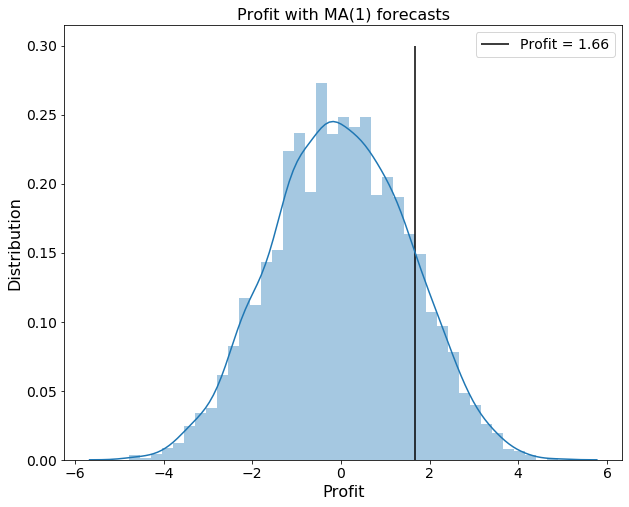

In [72]:
train_ts = train['USD']
val_ts = data['2019']['USD']
test_ts = test['USD']['2020']

y = test['USD']['2020']
ma1_pred = test['est_N1']['2020']
ma2_pred = test['est_N2']['2020']
ma3_pred = test['est_N3']['2020']
ma4_pred = test['est_N4']['2020']
ma10_pred = test['est_N10']['2020']
ma21_pred = test['est_N21']['2020']

ma1_profit, ma1_equity = backtest(y, ma1_pred)
plt.xlabel("Profit", fontsize=16)
plt.ylabel("Distribution", fontsize=16)
plt.title("Profit with MA(1) forecasts", fontsize=16)
_ = random_simulation(test_ts, ma1_profit)

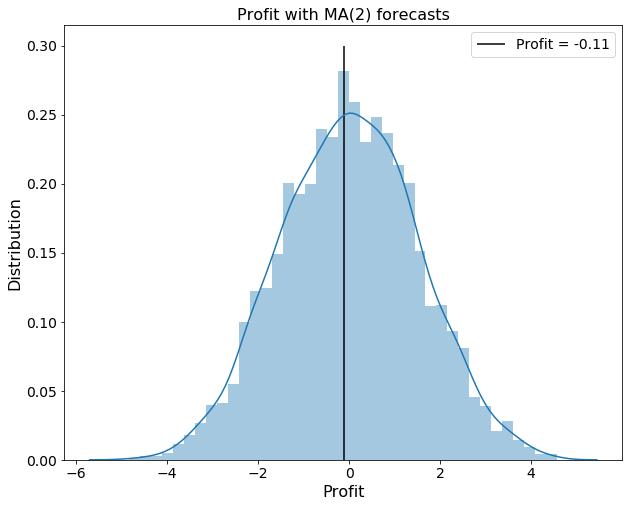

In [71]:
ma2_profit, ma2_equity = backtest(y, ma2_pred)
plt.xlabel("Profit", fontsize=16)
plt.ylabel("Distribution", fontsize=16)
plt.title("Profit with MA(2) forecasts", fontsize=16)
_ = random_simulation(test_ts, ma2_profit)

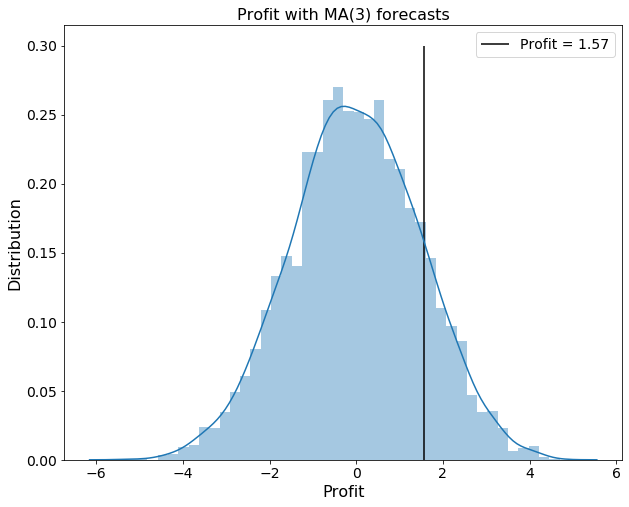

In [70]:
ma3_profit, ma3_equity = backtest(y, ma3_pred)
plt.xlabel("Profit", fontsize=16)
plt.ylabel("Distribution", fontsize=16)
plt.title("Profit with MA(3) forecasts", fontsize=16)
_ = random_simulation(test_ts, ma3_profit)

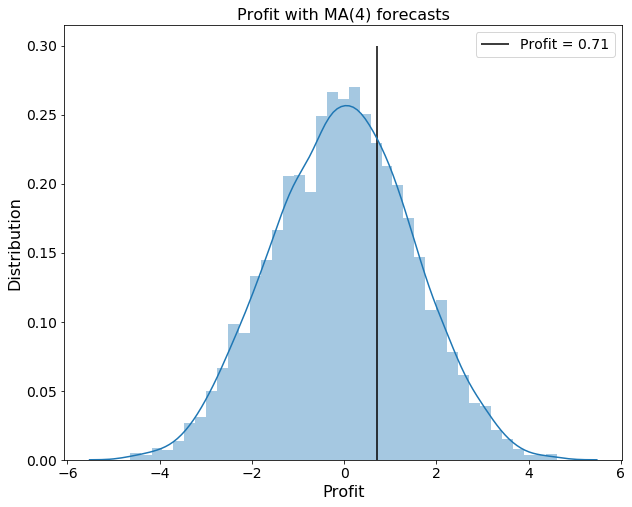

In [69]:
ma4_profit, ma4_equity = backtest(y, ma4_pred)
plt.xlabel("Profit", fontsize=16)
plt.ylabel("Distribution", fontsize=16)
plt.title("Profit with MA(4) forecasts", fontsize=16)
_ = random_simulation(test_ts, ma4_profit)

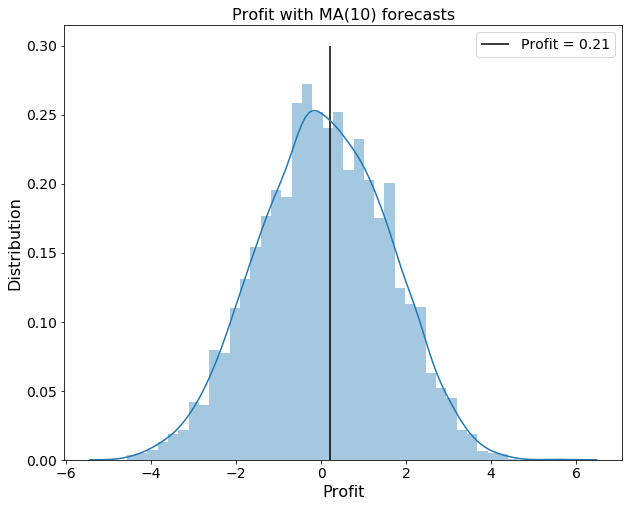

In [68]:
ma10_profit, ma10_equity = backtest(y, ma10_pred)

plt.xlabel("Profit", fontsize=16)
plt.ylabel("Distribution", fontsize=16)
plt.title("Profit with MA(10) forecasts", fontsize=16)
_ = random_simulation(test_ts, ma10_profit)

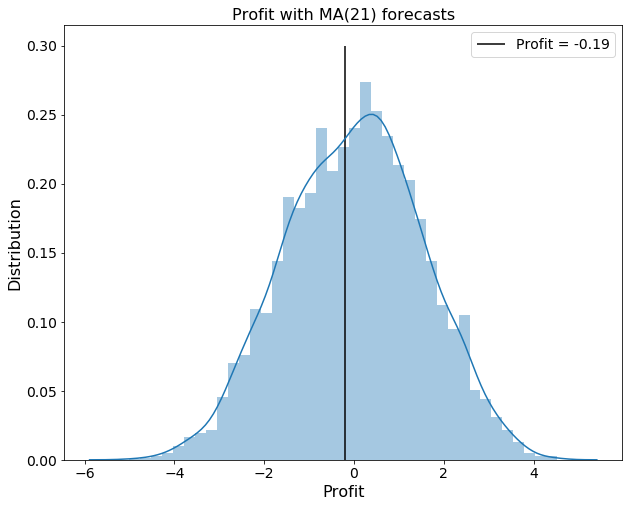

In [67]:
ma21_profit, ma21_equity = backtest(y, ma21_pred)

plt.xlabel("Profit", fontsize=16)
plt.ylabel("Distribution", fontsize=16)
plt.title("Profit with MA(21) forecasts", fontsize=16)

_ = random_simulation(test_ts, ma21_profit)